<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3"> 
   
# **Optimization Project 2**

</font>
</div>

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3"> 
   
**Group Members:**
- Abhijit Anil (aa94375) 
- Akash Goyal (ag84248)
- Jordan Ehlinger (je28596)
- Rahull Borana (rb47374)

**Problem Description**

Should airlines overbook flights? To passengers, it is annoying to be on an overbooked flight, but is it worth it to airlines? This project will expand the airline ticket pricing problem we worked in class to pick an optimal overbooking policy.
# 
You work for an airline in the pricing department, and you want to find the optimal pricing policy and number of tickets to offer for sale on a particular flight to maximize expected discounted profit, which comes from the revenue of ticket sales minus overbooking costs; there are of course other costs, but we’ll consider those to be fixed costs that we can’t optimize over. Revenue comes in from demand for tickets in the time before takeoff, where you will decide the optimal price to charge each day. Overbooking costs come in when more people show up for the flight than there are seats on the plane, if the flight is overbooked. In that case you must pay a stipend to the passengers who cannot get on the plane.
# 
The flight you’re analyzing has two ticket classes, coach and first-class. Your manager is not willing to allow overbooking in first-class, due to loss of goodwill from high-paying customers, but is open to the idea of overbooking coach. In the case that more people show up with tickets for coach than there are seats available in coach, you can bump ticket holders up to first-class if there are seats available in first-class. Everyone that gets bumped up to first-class from coach imposes an overbooking cost to the airline, because the service in first-class is more costly to the airline, and everyone that does not get a seat on the flight imposes a greater overbooking cost to the airline.
# 
When selling tickets in coach there are two possible ticket prices, each leading to different demand distributions, and there are two possible ticket prices for first-class, again leading to different demand distributions. We will assume that demand for coach and first-class seats are independent. On each day there will be either 0 or 1 ticket sold in coach and 0 or 1 ticket sold in first-class. The probability of a sale for each ticket class depends on the price of the ticket; just like in the example in class. If there is more demand for first-class than there are seats in first-class, customers won’t buy a coach seat. If there is more demand for coach seats than allowed by the overbooking policy, customers won’t buy a first-class seat. However, to account for the people who would usually book a first-class seat but can’t, when first-class is sold out, the chance of a sale in coach increases by 3 percentage points, regardless of the coach ticket price.
For a given overbooking policy you will find the optimal pricing policy using dynamic programming. You will solve this dynamic programming problem for several overbooking policies and find the overbooking policy with the largest expected discounted profit.

</font>
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
%matplotlib inline

In [2]:
price_C_L = 300
price_C_H = 350
p_C_L = [0.35,0.65] # demand probabilities for coach low price
p_C_H = [0.7,0.3] # demand probabilities for coach high price

p_C_L_New = [0.32,0.68] # demand probabilities for coach low price when first class is full
p_C_H_New = [0.67,0.33] # demand probabilities for coach high price when first class is full

price_F_L = 425
price_F_H = 500
p_F_L = [0.92,0.08] # demand probabilities for first class low price
p_F_H = [0.96,0.04] # demand probabilities for first class high price

delta = 0.9995344634 # discount rate

M_C = 100 # number of coach seats on plane
M_F = 20 # number of first class seats on plane
T = 365 # days until takeoff

overbooking_limit = 5  # maximum allowed coach overbooking

s_C_Values = np.arange(M_C+overbooking_limit+1) # all possible number of coach seats left
s_F_Values = np.arange(M_F+1) # all possible number of first class seats left
tValues = np.arange(T+1) # all possible days until takeoff
s_C_N = len(s_C_Values) # count possible state values for coach
s_F_N = len(s_F_Values) # count possible state values for first class
tN = len(tValues)

show_up_prob_C = 0.95  # probability of a coach passenger showing up
show_up_prob_F = 0.97  # probability of a first-class passenger showing up
bump_to_first_cost = 50  # cost of bumping a coach passenger to first-class
bump_off_cost = 425  # cost of bumping a coach passenger off the plane

In [3]:
V = np.zeros((s_C_N,s_F_N,tN)) # initialize value function
U = np.zeros((s_C_N,s_F_N,tN)) # initialize optimal choice variable

# boundary/terminal condition
# V[:,:,tN-1] = 0 # when the flight takes off you can't make any more money
U[:,:,tN-1] = 9 # 9 is the value for no tickets for sale


In [4]:
def value_matrix_calc(V, s_C_N, s_F_N):
    # Loop over the number of coach tickets booked in reverse order
    for sc in reversed(range(s_C_N)):  
        # Loop over the number of first-class tickets booked in reverse order
        for sf in reversed(range(s_F_N)):
            cost = 0  # Initialize cost for this combination of booked tickets

            # Loop over each possible number of coach passengers actually showing up
            for c_actual in range(sc + 1):
                # Calculate the probability of 'c_actual' number of coach passengers showing up
                if c_actual > M_C:
                    pr_c_actual = scipy.stats.binom.pmf(c_actual, sc, 0.95)
                    # Loop over each possible number of first-class passengers actually showing up
                    for tf_act in range(sf + 1):
                        # Calculate the probability of 'tf_act' number of first-class passengers showing up
                        pr_tf_act = scipy.stats.binom.pmf(tf_act, sf, 0.97)

                        # Check if coach passengers exceed capacity but not first class
                        if c_actual - M_C <= M_F - tf_act:
                            cost = cost - pr_c_actual * pr_tf_act * bump_to_first_cost * (c_actual - M_C)
                        else:
                            # Calculate cost for bumping passengers to first class and off the plane
                            cost = cost - pr_c_actual * pr_tf_act * (bump_to_first_cost * (M_F - tf_act) +
                                                                   bump_off_cost * (c_actual - M_C - (M_F - tf_act)))
            # Assign the calculated cost to the corresponding entry in the value matrix V
            V[s_C_N - sc - 1, s_F_N - sf - 1, tN - 1] = cost

    return V  # Return the updated value matrix


<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3"> 
   
### **Legend for Utility matrix choices**

* L: Low Price
* H: High price
* N: No sale

| Coach | First | Choice |
|-------|-------|--------|
| L     | L     | 1      |
| L     | H     | 2      |
| H     | L     | 3      |
| H     | H     | 4      |
| L     | N     | 5      |
| H     | N     | 6      |
| N     | L     | 7      |
| N     | H     | 8      |
| N     | N     | 9      |


</font>
</div>

In [5]:
def price_profit_calculator(V,U,s_C_N,s_F_N,mode):
    if mode == 1:
        for t in reversed(range(tN-1)):
            for s_c in range(s_C_N):
                for s_f in range(s_F_N):
                    if s_f==0: # is the flight full (0 seats left)
                        if s_c == 0:
                            V[s_c,s_f,t]=delta*V[s_c,s_f,t+1] # if so, you can't make any more money
                            U[s_c,s_f,t]=9 # no tickets for sale
                        else:
                            valueL_N = p_C_L_New[1]*price_C_L + delta* (p_C_L_New[0]*V[s_c,s_f,t+1] + p_C_L_New[1]*V[s_c-1,s_f,t+1])

                            valueH_N = p_C_H_New[1]*price_C_H + delta* (p_C_H_New[0]*V[s_c,s_f,t+1] + p_C_H_New[1]*V[s_c-1,s_f,t+1])

                            V[s_c,s_f,t]=max(valueL_N,valueH_N) # value funciton maximizes expected revenue

                            U[s_c,s_f,t]=np.argmax([valueL_N,valueH_N])+5 # choice of price: 5 means coach low price, 6 means coach high price
                    else:
                        if s_c == 0:
                            valueN_L = p_F_L[1]*price_F_L + delta* (p_F_L[0]*V[s_c,s_f,t+1] + p_F_L[1]*V[s_c,s_f-1,t+1])

                            valueN_H = p_F_H[1]*price_F_H + delta* (p_F_H[0]*V[s_c,s_f,t+1] + p_F_H[1]*V[s_c,s_f-1,t+1])

                            V[s_c,s_f,t]=max(valueN_L,valueN_H) # value funciton maximizes expected revenue

                            U[s_c,s_f,t]=np.argmax([valueN_L,valueN_H])+7 # choice of price: 7 means first class low price, 8 means first class high price

                        else:
                            valueL_L = p_C_L[1]*price_C_L + p_F_L[1]*price_F_L + delta* (p_C_L[0]* p_F_L[0]*V[s_c,s_f,t+1]
                                                                                        +p_C_L[0]* p_F_L[1]*V[s_c,s_f-1,t+1]
                                                                                        +p_C_L[1]* p_F_L[0]*V[s_c-1,s_f,t+1]
                                                                                        +p_C_L[1]* p_F_L[1]*V[s_c-1,s_f-1,t+1])

                            valueL_H = p_C_L[1]*price_C_L + p_F_H[1]*price_F_H + delta* (p_C_L[0]* p_F_H[0]*V[s_c,s_f,t+1]
                                                                                        +p_C_L[0]* p_F_H[1]*V[s_c,s_f-1,t+1]
                                                                                        +p_C_L[1]* p_F_H[0]*V[s_c-1,s_f,t+1]
                                                                                        +p_C_L[1]* p_F_H[1]*V[s_c-1,s_f-1,t+1])

                            valueH_L = p_C_H[1]*price_C_H + p_F_L[1]*price_F_L + delta* (p_C_H[0]* p_F_L[0]*V[s_c,s_f,t+1]
                                                                                        +p_C_H[0]* p_F_L[1]*V[s_c,s_f-1,t+1]
                                                                                        +p_C_H[1]* p_F_L[0]*V[s_c-1,s_f,t+1]
                                                                                        +p_C_H[1]* p_F_L[1]*V[s_c-1,s_f-1,t+1])

                            valueH_H = p_C_H[1]*price_C_H + p_F_H[1]*price_F_H + delta* (p_C_H[0]* p_F_H[0]*V[s_c,s_f,t+1]
                                                                                        +p_C_H[0]* p_F_H[1]*V[s_c,s_f-1,t+1]
                                                                                        +p_C_H[1]* p_F_H[0]*V[s_c-1,s_f,t+1]
                                                                                        +p_C_H[1]* p_F_H[1]*V[s_c-1,s_f-1,t+1])


                    

                            V[s_c,s_f,t]=max(valueL_L,valueL_H,valueH_L,valueH_H) # value funciton maximizes expected revenue

                            U[s_c,s_f,t]=np.argmax([valueL_L,valueL_H,valueH_L,valueH_H])+1 # choice of price: 1 means both low price, 2 means high coach, low first price ,3 means high first class low first coach, 4 means both low price
    if mode ==2:
        for t in reversed(range(tN-1)):
            for s_c in range(s_C_N):
                for s_f in range(s_F_N):
                    if s_f==0: # is the flight full (0 seats left)
                        if s_c == 0:
                            V[s_c,s_f,t]=delta*V[s_c,s_f,t+1] # if so, you can't make any more money
                            U[s_c,s_f,t]=9 # no tickets for sale
                        else:
                            valueL_N = p_C_L_New[1]*price_C_L + delta* (p_C_L_New[0]*V[s_c,s_f,t+1] + p_C_L_New[1]*V[s_c-1,s_f,t+1])

                            valueH_N = p_C_H_New[1]*price_C_H + delta* (p_C_H_New[0]*V[s_c,s_f,t+1] + p_C_H_New[1]*V[s_c-1,s_f,t+1])

                            valueN_N = delta*V[s_c,s_f,t+1]

                            V[s_c,s_f,t]=max(valueL_N,valueH_N,valueN_N) # value funciton maximizes expected revenue
                            choice = np.argmax([valueL_N,valueH_N,valueN_N])
                            if choice == 2:
                                U[s_c,s_f,t] = 9 # no tickets for sale
                            else:
                                U[s_c,s_f,t] = choice + 5 # choice of price: 5 means coach low price, 6 means coach high price
                    else:
                        if s_c == 0:
                            valueN_L = p_F_L[1]*price_F_L + delta* (p_F_L[0]*V[s_c,s_f,t+1] + p_F_L[1]*V[s_c,s_f-1,t+1])

                            valueN_H = p_F_H[1]*price_F_H + delta* (p_F_H[0]*V[s_c,s_f,t+1] + p_F_H[1]*V[s_c,s_f-1,t+1])

                            V[s_c,s_f,t]=max(valueN_L,valueN_H) # value funciton maximizes expected revenue

                            U[s_c,s_f,t]=np.argmax([valueN_L,valueN_H])+7 # choice of price: 7 means first class low price, 8 means first class high price

                        else:
                            valueN_L = p_F_L[1]*price_F_L + delta* (p_F_L[0]*V[s_c,s_f,t+1] + p_F_L[1]*V[s_c,s_f-1,t+1])

                            valueN_H = p_F_H[1]*price_F_H + delta* (p_F_H[0]*V[s_c,s_f,t+1] + p_F_H[1]*V[s_c,s_f-1,t+1])

                            valueL_L = p_C_L[1]*price_C_L + p_F_L[1]*price_F_L + delta* (p_C_L[0]* p_F_L[0]*V[s_c,s_f,t+1]
                                                                                        +p_C_L[0]* p_F_L[1]*V[s_c,s_f-1,t+1]
                                                                                        +p_C_L[1]* p_F_L[0]*V[s_c-1,s_f,t+1]
                                                                                        +p_C_L[1]* p_F_L[1]*V[s_c-1,s_f-1,t+1])# + p_C_L[1]*V[s_c-1,s_f,t+1] + p_F_L[0]*V[s_c,s_f,t+1] + p_F_L[1]*V[s_c,s_f-1,t+1])

                            valueL_H = p_C_L[1]*price_C_L + p_F_H[1]*price_F_H + delta* (p_C_L[0]* p_F_H[0]*V[s_c,s_f,t+1]
                                                                                        +p_C_L[0]* p_F_H[1]*V[s_c,s_f-1,t+1]
                                                                                        +p_C_L[1]* p_F_H[0]*V[s_c-1,s_f,t+1]
                                                                                        +p_C_L[1]* p_F_H[1]*V[s_c-1,s_f-1,t+1])#p_C_L[0]*V[s_c,s_f,t+1] + p_C_L[1]*V[s_c-1,s_f,t+1] + p_F_H[0]*V[s_c,s_f,t+1] + p_F_H[1]*V[s_c,s_f-1,t+1])

                            valueH_L = p_C_H[1]*price_C_H + p_F_L[1]*price_F_L + delta* (p_C_H[0]* p_F_L[0]*V[s_c,s_f,t+1]
                                                                                        +p_C_H[0]* p_F_L[1]*V[s_c,s_f-1,t+1]
                                                                                        +p_C_H[1]* p_F_L[0]*V[s_c-1,s_f,t+1]
                                                                                        +p_C_H[1]* p_F_L[1]*V[s_c-1,s_f-1,t+1])#p_C_H[0]*V[s_c,s_f,t+1] + p_C_H[1]*V[s_c-1,s_f,t+1] + p_F_L[0]*V[s_c,s_f,t+1] + p_F_L[1]*V[s_c,s_f-1,t+1])

                            valueH_H = p_C_H[1]*price_C_H + p_F_H[1]*price_F_H + delta* (p_C_H[0]* p_F_H[0]*V[s_c,s_f,t+1]
                                                                                        +p_C_H[0]* p_F_H[1]*V[s_c,s_f-1,t+1]
                                                                                        +p_C_H[1]* p_F_H[0]*V[s_c-1,s_f,t+1]
                                                                                        +p_C_H[1]* p_F_H[1]*V[s_c-1,s_f-1,t+1])#p_C_H[0]*V[s_c,s_f,t+1] + p_C_H[1]*V[s_c-1,s_f,t+1] + p_F_H[0]*V[s_c,s_f,t+1] + p_F_H[1]*V[s_c,s_f-1,t+1])


                    

                            V[s_c,s_f,t]=max(valueL_L,valueL_H,valueH_L,valueH_H,valueN_L,valueN_H) # value funciton maximizes expected revenue
                            choice = np.argmax([valueL_L,valueL_H,valueH_L,valueH_H,valueN_L,valueN_H])
                            if choice > 3:
                                U[s_c,s_f,t] = 9 # no tickets for sale
                            else:
                                U[s_c,s_f,t] = choice + 1 # choice of price: 1 means both low price, 2 means high coach, low first price ,3 means high first class low first coach, 4 means both low price

    return V,U

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3"> 

# **Q 1**

Assume there are 365 days until the plane departs, so you have 365 opportunities to sell tickets, after that people either show up or not to the flight/terminal. There are 100 seats in coach and 20 seats in first-class. Each coach ticket holder shows up to the flight with probability 95%, and each first-class ticket holder shows up to the flight with probability 97%. You can charge $300 or $350 for coach tickets, and you can charge $425 or $500 for first-class tickets. On each day, if the price is $300 for coach there is a 65% chance a coach ticket is sold, if the price is $350 for coach there is a 30% chance a coach ticket is sold, if the price is $425 for first-class there is an 8% chance a first-class ticket is sold, and if the price is $500 for first-class there is a 4% chance a first-class ticket is sold. For the first iteration, examine the expected discounted revenue when you allow coach to be oversold by 5 seats. It costs the airline $50 to bump a coach passenger to first-class and it costs the airline $425 to bump a coach passenger off the plane. The discount rate is 17% per year, so the daily discount factor is 1/(1+0.17/365). What is the expected discounted profit of selling these tickets and paying out overbooking costs over the course of the year?
*  On the day the flight takes off there is no revenue, only costs. You can calculate the expected cost using the binomial distribution (scipy.stats.binom.pmf), where the number of trials is the number of tickets sold, and a success is if a passenger shows up for the flight.
*  Remember, when first-class is sold out if the coach price is $300, then the chance of a sale increases from 65% to 68%, and if the coach price is $350 then the chance of a sale increases from 30% to 33%.

</font>
</div>

In [6]:
# Call the value_matrix_calc function to calculate the value matrix V based on the current state
# and the number of coach and first-class seats available.
# This function iteratively calculates the value for each state (number of coach and first-class tickets booked)
# considering the probabilities of passengers showing up, pricing strategies, and bumping costs.

V = value_matrix_calc(V, s_C_N, s_F_N)


In [7]:
# Call the price_profit_calculator function to calculate the value matrix V and the optimal choice matrix U
# based on the current state, number of coach and first-class seats available, and mode 1.
# Mode 1 indicates specific calculations for prices and profits according to the defined conditions.
V, U = price_profit_calculator(V, U, s_C_N, s_F_N, mode=1)


<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3"> 

### Profit for 5 overbooked seats

</font>
</div>

In [8]:
# Calculate total revenue
V[105,20,0]

41886.158620004084

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3"> 

### Generate a scatter plot in 3-dimension representing the booking strategy

</font>
</div>

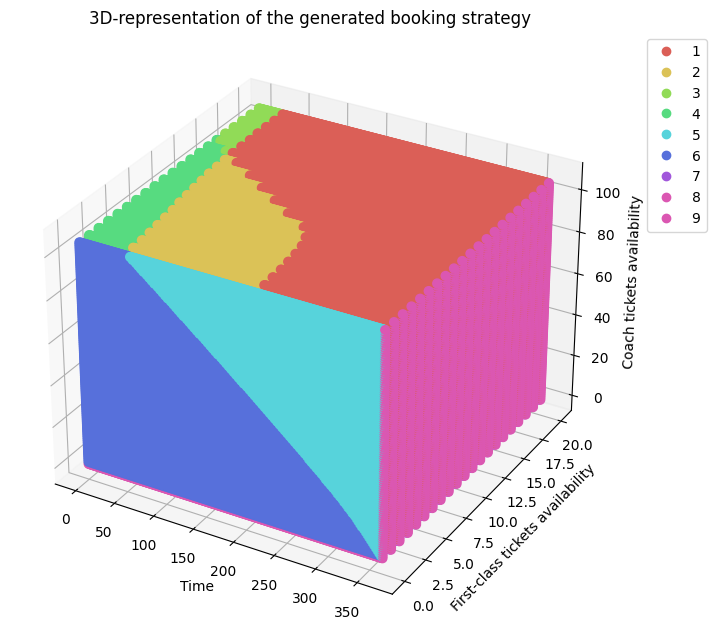

In [9]:

z, y, x = U.nonzero()
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette('hls',8).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=U[z,y,x], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('Time')
ax.set_ylabel('First-class tickets availability')
ax.set_zlabel('Coach tickets availability')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

plt.title('3D-representation of the generated booking strategy')
plt.show()

This graph shows us the price(low/high/none for both first class and coach) that should be charged for the seats based on the combination of time and seats. 

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3"> 
   
### **Legend for Utility matrix choices**

* L: Low Price
* H: High price
* N: No sale

| Coach | First | Choice |
|-------|-------|--------|
| L     | L     | 1      |
| L     | H     | 2      |
| H     | L     | 3      |
| H     | H     | 4      |
| L     | N     | 5      |
| H     | N     | 6      |
| N     | L     | 7      |
| N     | H     | 8      |
| N     | N     | 9      |


</font>
</div>

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3"> 

# **Q 2**

Repeat step (1) while allowing coach to be oversold by 6, 7, 8, …, 15 seats. Which overbooking policy from this leads to the largest profits by the airline?

</font>
</div>

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3"> 

### 5 to 16 seats

</font>
</div>

In [10]:
# Calculate expected profits for different numbers of extra seats ranging from 5 to 15.
extra_seats = [i for i in range(5, 16)]
expected_profit = {}  # Dictionary to store expected profits for each number of extra seats.

# Iterate over each number of extra seats.
for e in extra_seats:
    s_C_Values = np.arange(M_C + e + 1)  # All possible numbers of coach seats left, including extra seats.
    s_C_N = len(s_C_Values)  # Count possible state values for coach seats.

    V = np.zeros((s_C_N, s_F_N, tN))  # Initialize the value function matrix.
    U = np.zeros((s_C_N, s_F_N, tN))  # Initialize the optimal choice variable matrix.

    # Boundary/terminal condition: set values for the last day (when the flight takes off).
    U[:, :, tN - 1] = 9  # Value 0 means no tickets for sale.

    # Calculate the value matrix V based on the current state and number of coach and first-class seats available.
    V = value_matrix_calc(V, s_C_N, s_F_N)

    # Calculate the value matrix V and the optimal choice matrix U for pricing and profit calculation in mode 1.
    V, U = price_profit_calculator(V, U, s_C_N, s_F_N, mode=1)

    # Store the expected profit for the current number of extra seats in the dictionary.
    expected_profit[e] = V[s_C_N - 1, s_F_N - 1, 0]  # Retrieve the profit for full coach and first-class seats.


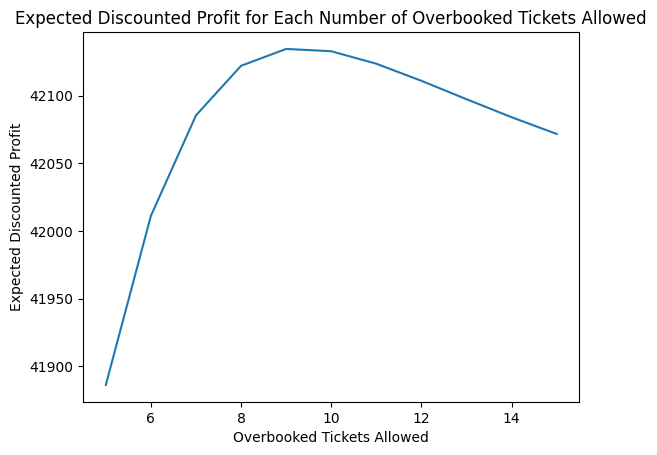

In [11]:
plt.plot(expected_profit.keys(),expected_profit.values())
plt.xlabel('Overbooked Tickets Allowed')
plt.ylabel('Expected Discounted Profit')
plt.title('Expected Discounted Profit for Each Number of Overbooked Tickets Allowed')
plt.show()

In [12]:
expected_profit

{5: 41886.158620004084,
 6: 42011.22105622885,
 7: 42085.53615159907,
 8: 42122.16726452604,
 9: 42134.624826100386,
 10: 42132.900378107086,
 11: 42123.66593133525,
 12: 42111.02966623274,
 13: 42097.41950563192,
 14: 42084.11156610864,
 15: 42071.7423050648}

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3"> 

### Therefore we observe the maximum expected profit when we sell 9 extra coach seats

</font>
</div>

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3"> 

# **Q 3**

Compare the previous policy, where there is a hard cap on seats sold, to another strategy where there is a third choice on each day when you’re deciding ticket prices. Consider a new policy that allows the airline to choose to sell no coach tickets on a day if it wants; the airline has the option to force demand to 0 on a day. Now there are 3 choices each day for coach: high price, low price, and no sale. There are still just 2 choices each day for first class: high and low price. Assume that the airline will never sell more than 120 seats in coach, but on any one day they can choose to not sell coach tickets. This way they can stop over-selling tickets not just based on how many they have sold, but also on how many days are left to sell. Does this policy have a better or worse expected profit than the best policy from step 2?

</font>
</div>

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3"> 

### Modified policy calculations

</font>
</div>

In [13]:
# Define possible values for coach seats, first-class seats, and days until takeoff, considering additional 20 coach seats.
s_C_Values = np.arange(M_C + 20 + 1)  # All possible number of coach seats left, including extra seats.
s_F_Values = np.arange(M_F + 1)  # All possible number of first-class seats left.
tValues = np.arange(T + 1)  # All possible days until takeoff.

s_C_N = len(s_C_Values)  # Count possible state values for coach seats.
s_F_N = len(s_F_Values)  # Count possible state values for first-class seats.
tN = len(tValues)  # Count possible state values for days until takeoff.

V_2 = np.zeros((s_C_N, s_F_N, tN))  # Initialize the value function matrix for the modified scenario.
U_2 = np.zeros((s_C_N, s_F_N, tN))  # Initialize the optimal choice variable matrix for the modified scenario.

# Boundary/terminal condition: set values for the last day (when the flight takes off).
U_2[:, :, tN - 1] = 9  # Value 9 means no tickets for sale.

# Calculate the value matrix V_2 based on the current state and number of coach and first-class seats available,
# considering the additional 20 coach seats.
V_2 = value_matrix_calc(V_2, s_C_N, s_F_N)


In [14]:
# Call the price_profit_calculator function to calculate the value matrix V and the optimal choice matrix U
# based on the current state, number of coach and first-class seats available, and mode 2.
# Mode 2 indicates specific calculations for prices and profits according to the defined conditions.


V_2,U_2 = price_profit_calculator(V_2,U_2,s_C_N,s_F_N,mode=2)

In [15]:
# Calculate total revenue
V_2[120,20,0]

42139.89275807359

In [16]:
# Calculate expected profits for a modified scenario with varying numbers of extra seats ranging from 5 to 20.
extra_seats = [i for i in range(5, 21)]
expected_profit_mod = {}  # Dictionary to store expected profits for each number of extra seats.

# Iterate over each number of extra seats in the modified scenario.
for e in extra_seats:
    s_C_Values = np.arange(M_C + e + 1)  # All possible numbers of coach seats left, including extra seats.
    s_C_N = len(s_C_Values)  # Count possible state values for coach seats.

    V = np.zeros((s_C_N, s_F_N, tN))  # Initialize the value function matrix.
    U = np.zeros((s_C_N, s_F_N, tN))  # Initialize the optimal choice variable matrix.

    # Boundary/terminal condition: set values for the last day (when the flight takes off).
    U[:, :, tN - 1] = 9  # Value 9 means no tickets for sale.

    # Calculate the value matrix V based on the current state and number of coach and first-class seats available.
    V = value_matrix_calc(V, s_C_N, s_F_N)

    # Calculate the value matrix V and the optimal choice matrix U for pricing and profit calculation in mode 2
    # (modified scenario).
    V, U = price_profit_calculator(V, U, s_C_N, s_F_N, mode=2)

    # Store the expected profit for the current number of extra seats in the dictionary.
    expected_profit_mod[e] = V[s_C_N - 1, s_F_N - 1, 0]  # Retrieve the profit for full coach and first-class seats.


In [17]:
expected_profit_mod

{5: 41886.158620004084,
 6: 42011.22105622885,
 7: 42085.53615159907,
 8: 42122.16726452604,
 9: 42134.624826100386,
 10: 42138.14049366884,
 11: 42139.32793557274,
 12: 42139.70894082022,
 13: 42139.831420699826,
 14: 42139.87222068783,
 15: 42139.88607681836,
 16: 42139.89070687318,
 17: 42139.89217899643,
 18: 42139.892613020354,
 19: 42139.89272977839,
 20: 42139.89275807359}

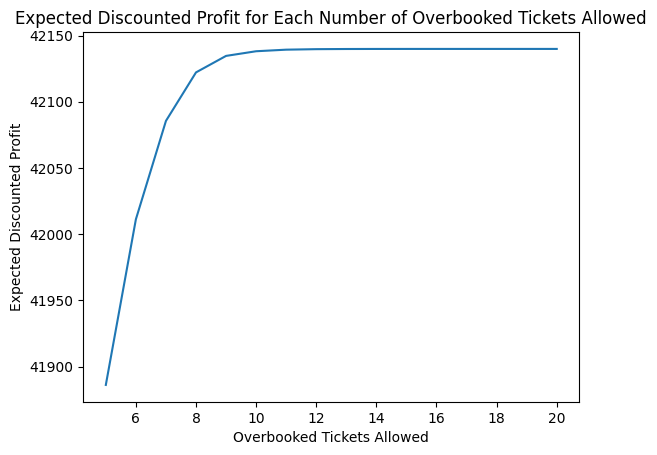

In [18]:
plt.plot(expected_profit_mod.keys(),expected_profit_mod.values())
plt.xlabel('Overbooked Tickets Allowed')
plt.ylabel('Expected Discounted Profit')
plt.title('Expected Discounted Profit for Each Number of Overbooked Tickets Allowed')
plt.show()

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3"> 

### With the new policy, we can consider selling 11 extra seats as the expected profit is pretty steady after that

</font>
</div>

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3"> 
   
# **Q 4**

Now that you have solved the problem backwards, use the optimal overbooking policy to simulate the solution forward many times. How often is coach overbooked? How often are passengers kicked off the plane? What is the average overbooking cost? What is the volatility of discounted profits? Are there any other interesting questions you can think of? Make a few graphs to examine these questions. Do this for both policies above.

</font>
</div>

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3"> 
   
### We use the optimal overbooking policy to simulate the solution forward many times. How often is coach overbooked? 

- How often are passengers kicked off the plane? 
- What is the average overbooking cost? 
- What is the volatility of discounted profits? 
- Are there any other interesting questions you can think of? 
- Make a few graphs to examine these questions. Do this for both policies above

</font>
</div>


<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3"> 
   
### **Legend for Utility matrix choices**

* L: Low Price
* H: High price
* N: No sale

| Coach | First | Choice |
|-------|-------|--------|
| L     | L     | 1      |
| L     | H     | 2      |
| H     | L     | 3      |
| H     | H     | 4      |
| L     | N     | 5      |
| H     | N     | 6      |
| N     | L     | 7      |
| N     | H     | 8      |
| N     | N     | 9      |


</font>
</div>

In [19]:
price_C_L = 300
price_C_H = 350
p_C_L = [0.35,0.65] # demand probabilities for coach low price
p_C_H = [0.7,0.3] # demand probabilities for coach high price

p_C_L_New = [0.32,0.68] # demand probabilities for coach low price when first class is full
p_C_H_New = [0.67,0.33] # demand probabilities for coach high price when first class is full

price_F_L = 425
price_F_H = 500
p_F_L = [0.92,0.08] # demand probabilities for first class low price
p_F_H = [0.96,0.04] # demand probabilities for first class high price

delta = 0.9995344634 # discount rate

M_C = 100 # number of coach seats on plane
M_F = 20 # number of first class seats on plane
T = 365 # days until takeoff

overbooking_limit = 5  # maximum allowed coach overbooking

s_C_Values = np.arange(M_C+overbooking_limit+1) # all possible number of coach seats left
s_F_Values = np.arange(M_F+1) # all possible number of first class seats left
tValues = np.arange(T+1) # all possible days until takeoff
s_C_N = len(s_C_Values) # count possible state values for coach
s_F_N = len(s_F_Values) # count possible state values for first class
tN = len(tValues)

show_up_prob_C = 0.95  # probability of a coach passenger showing up
show_up_prob_F = 0.97  # probability of a first-class passenger showing up
bump_to_first_cost = 50  # cost of bumping a coach passenger to first-class
bump_off_cost = 425  # cost of bumping a coach passenger off the plane

In [20]:
# This function accepts the number of extra seats allocated for overbooking and the associated decision matrix.
# It calculates and returns the expected profit, the count of coach and first-class tickets booked, as well as the actual number of coach and first-class passengers who show up during departure

def simulator(U,extra):
    # Calculate available seats in coach on the first day
    sc = 100 + extra

    # Set available seats in first-class on the first day
    sf = 20

    # Define the total number of days in the simulation (including day 0)
    tN = 366  # 0-365 is 366 values

    # Initialize total revenue from coach and first-class ticket sales
    total_rev_c = 0
    total_rev_f = 0

    # Initialize arrays to track remaining seats in coach and first-class after each day
    seatsc_left_vec = np.zeros(tN - 1)
    seatsf_left_vec = np.zeros(tN - 1)

    # Initialize arrays to track discounted revenue generated from coach and first-class sales after each day
    revenuec_vec = np.zeros(tN - 1)
    revenuef_vec = np.zeros(tN - 1)

    
    for t in range(tN-1):  # Loop forward in time, excluding the last time period as no sales can occur then
        opt_price = int(U[sc, sf, t])  # Determine the optimal price for coach tickets

        # Set actual prices and probabilities of sale based on the optimal price scenario
        if opt_price == 1:  # Both coach and first-class tickets are sold at low prices
            actual_coach_price = price_C_L
            actual_fc_price = price_F_L
            prob_sale_c = p_C_L[1]
            prob_sale_f = p_F_L[1]

        elif opt_price == 2:  # Coach ticket is sold at low price, first-class ticket is sold at high price
            actual_coach_price = price_C_L
            actual_fc_price = price_F_H
            prob_sale_c = p_C_L[1]
            prob_sale_f = p_F_H[1]

        elif opt_price == 3:  # Coach ticket is sold at high price, first-class ticket is sold at low price
            actual_coach_price = price_C_H
            actual_fc_price = price_F_L
            prob_sale_c = p_C_H[1]
            prob_sale_f = p_F_L[1]

        elif opt_price == 4:  # Both coach and first-class tickets are sold at high prices
            actual_coach_price = price_C_H
            actual_fc_price = price_F_H
            prob_sale_c = p_C_H[1]
            prob_sale_f = p_F_H[1]

        elif opt_price == 5:  # Coach ticket is sold at low price, first-class tickets are sold out
            actual_coach_price = price_C_L
            actual_fc_price = 0
            prob_sale_c = p_C_L_New[1]
            prob_sale_f = 0

        elif opt_price == 6:  # Coach ticket is sold at high price, first-class tickets are sold out
            actual_coach_price = price_C_H
            actual_fc_price = 0
            prob_sale_c = p_C_H_New[1]
            prob_sale_f = 0

        elif opt_price == 7:  # Coach tickets are sold out, first-class ticket is sold at low price
            actual_coach_price = 0
            actual_fc_price = price_F_L
            prob_sale_c = 0
            prob_sale_f = p_F_L[1]

        elif opt_price == 8:  # Coach tickets are sold out, first-class ticket is sold at high price
            actual_coach_price = 0
            actual_fc_price = price_F_H
            prob_sale_c = 0
            prob_sale_f = p_F_H[1]

        else:  # No tickets are available for sale
            actual_coach_price = 0
            actual_fc_price = 0
            prob_sale_c = 0
            prob_sale_f = 0


        sale_c = (np.random.random(1) < prob_sale_c)  # Simulate whether a coach sale was made or not
        sale_f = (np.random.random(1) < prob_sale_f)  # Simulate whether a first-class sale was made or not

        # When the flight is full, the probability of sale is 0, so no sales can occur
        sc = int(sc - sale_c)  # Subtract whether or not a sale was made in coach
        sf = int(sf - sale_f)  # Subtract whether or not a sale was made in first-class

        # Calculate and accumulate discounted revenue generated from coach and first-class sales
        total_rev_c = total_rev_c + int(sale_c) * actual_coach_price * (delta ** (t))
        total_rev_f = total_rev_f + int(sale_f) * actual_fc_price * (delta ** (t))

        # Save the results in the corresponding arrays
        seatsc_left_vec[t] = sc
        seatsf_left_vec[t] = sf
        revenuec_vec[t] = total_rev_c
        revenuef_vec[t] = total_rev_f

    total_rev = total_rev_c + total_rev_f  # Calculate total revenue generated
    tc = 100 + extra - sc  # Calculate total number of coach tickets sold
    tf = 20 - sf  # Calculate total number of first-class tickets sold

    # Simulate actual number of coach passengers who show up during departure
    c_actual = (np.random.choice([1, 0], tc, p=[0.95, 0.05])).sum()

    # Simulate actual number of first-class passengers who show up during departure
    tf_act = (np.random.choice([1, 0], tf, p=[0.97, 0.03])).sum()

    # Calculate cost based on actual passenger numbers
    if c_actual < 100:  # If actual coach passengers are less than capacity
        cost = 0
    elif c_actual - 100 < 20 - tf_act:  # If actual coach passengers exceed capacity but not first-class vacancies
        cost = bump_to_first_cost * (c_actual - 100)
    else:  # If actual coach passengers exceed capacity and first-class vacancies
        cost = bump_to_first_cost * (20 - tf_act) + bump_off_cost * ((c_actual - 100) - (20 - tf_act))

    
    profit = total_rev - (delta**(tN-1))*cost
    ctoout_count = max(0,(c_actual-100)-(20-tf_act))
    
    return tc,tf,c_actual,tf_act,profit,ctoout_count,cost


In [21]:
def graph_generator(profits_list, cost_list, tc_list, tf_list, c_actual_list, tf_act_list, ctoout_count_list):

    # Profit Distribution
    plt.figure(figsize=(8, 6))  # Set the figure size
    # Plot the histogram of profits_list
    plt.hist(profits_list, edgecolor='black', alpha=0.7)
    # Calculate the mean of profits_list
    mean_profit = np.array(profits_list).mean()
    # Add a vertical dashed line for the mean profit
    plt.axvline(mean_profit, color='red', linestyle='dashed', linewidth=1.5)
    # Annotate the mean value on the plot with improved readability and positioning
    plt.text(mean_profit + (plt.xlim()[1] - plt.xlim()[0]) * 0.02, plt.ylim()[1] * 0.85, 
        f'Mean: {mean_profit:.2f}', color='red', fontsize=12,
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    # Set plot title and axis labels
    plt.title('Distribution of Profits')
    plt.xlabel('Profit')
    plt.ylabel('Frequency')
    # Show the plot
    plt.show()


    # Overbooking Cost Distribution
    plt.figure(figsize=(8, 6))  # Set the figure size
    # Plot the histogram of cost_list
    plt.hist(cost_list, edgecolor='black', alpha=0.7)
    # Calculate the mean of cost_list
    mean_cost = np.array(cost_list).mean()
    # Add a vertical dashed line for the mean cost
    plt.axvline(mean_cost, color='red', linestyle='dashed', linewidth=1.5)
    # Annotate the mean value on the plot with improved readability and positioning
    plt.text(mean_cost + (plt.xlim()[1] - plt.xlim()[0]) * 0.02, plt.ylim()[1] * 0.85, 
        f'Mean: {mean_cost:.2f}', color='red', fontsize=12,
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    # Set plot title and axis labels
    plt.title('Overbooking Cost Distribution')
    plt.xlabel('Overbooking Cost')
    plt.ylabel('Frequency')
    # Show the plot
    plt.show()


    # Coach seats booked Distribution
    plt.figure(figsize=(8, 6))  # Set the figure size
    # Plot the histogram of tc_list 
    plt.hist(tc_list, edgecolor='black', alpha=0.7)
    # Calculate the mean of tc_list
    mean_value = np.array(tc_list).mean()
    # Add a vertical dashed line for the mean number of coach seats booked
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1.5)
    # Annotate the mean value on the plot
    plt.text(mean_value + (plt.xlim()[1] - plt.xlim()[0]) * 0.02, plt.ylim()[1] * 0.85, 
            f'Mean: {mean_value:.2f}', color='red', fontsize=12,
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    # Set plot title and axis labels
    plt.title('Coach Seats Booked Distribution')
    plt.xlabel('Coach Seats Booked')
    plt.ylabel('Count')
    # Show the plot
    plt.show()


    # First-class seats booked Distribution
    plt.figure(figsize=(8, 6))  # Set the figure size
    # Plot the histogram of tf_list
    plt.hist(tf_list,  edgecolor='black', alpha=0.7)
    # Calculate the mean of tc_list
    mean_value = np.array(tf_list).mean()
    # Add a vertical dashed line for the mean number of coach seats booked
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1.5)
    # Annotate the mean value on the plot
    plt.text(mean_value + (plt.xlim()[1] - plt.xlim()[0]) * 0.02, plt.ylim()[1] * 0.85, 
            f'Mean: {mean_value:.2f}', color='red', fontsize=12,
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    # Set plot title and axis labels
    plt.title('First-class Seats Booked Distribution')
    plt.xlabel('First-class Seats Booked')
    plt.ylabel('Count')
    # Show the plot
    plt.show()


    # Actual Coach Passengers
    plt.figure(figsize=(8, 6))  # Set the figure size
    # Plot the histogram of tf_list
    plt.hist(c_actual_list,  edgecolor='black', alpha=0.7)
    # Calculate the mean of tc_list
    mean_value = np.array(c_actual_list).mean()
    # Add a vertical dashed line for the mean number of coach seats booked
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1.5)
    # Annotate the mean value on the plot
    plt.text(mean_value + (plt.xlim()[1] - plt.xlim()[0]) * 0.02, plt.ylim()[1] * 0.85, 
            f'Mean: {mean_value:.2f}', color='red', fontsize=12,
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    # Set plot title and axis labels
    plt.title('Distribution of Actual Coach passengers showing up during departure')
    plt.xlabel('Actual Coach passengers')
    plt.ylabel('Count')
    # Show the plot
    plt.show()


    # Actual First-class passengers
    plt.figure(figsize=(8, 6))  # Set the figure size
    # Plot the histogram of tf_act_list
    plt.hist(tf_act_list,  edgecolor='black', alpha=0.7)
    # Calculate the mean of tc_list
    mean_value = np.array(tf_act_list).mean()
    # Add a vertical dashed line for the mean number of coach seats booked
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1.5)
    # Annotate the mean value on the plot
    plt.text(mean_value + (plt.xlim()[1] - plt.xlim()[0]) * 0.02, plt.ylim()[1] * 0.85, 
            f'Mean: {mean_value:.2f}', color='red', fontsize=12,
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    # Set plot title and axis labels
    plt.title('Distribution of Actual First-class passengers showing up during departure')
    plt.xlabel('Actual First-class passengers')
    plt.ylabel('Count')
    # Show the plot
    plt.show()


    # Passengers kicked off the plane
    plt.figure(figsize=(8, 6))  # Set the figure size
    # Plot the histogram of ctoout_count_list
    plt.hist(ctoout_count_list, edgecolor='black', alpha=0.7)
    # Calculate the mean of tc_list
    mean_value = np.array(ctoout_count_list).mean()
    # Add a vertical dashed line for the mean number of coach seats booked
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1.5)
    # Annotate the mean value on the plot
    plt.text(mean_value + (plt.xlim()[1] - plt.xlim()[0]) * 0.02, plt.ylim()[1] * 0.85, 
            f'Mean: {mean_value:.2f}', color='red', fontsize=12,
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    # Set plot title and axis labels
    plt.title('Distribution of Passengers Kicked Off the Plane')
    plt.xlabel('Passengers Kicked Off the Plane')
    plt.ylabel('Frequency')
    # Show the plot
    plt.show()



In [22]:
e=9
s_C_Values = np.arange(M_C + e + 1)  # All possible numbers of coach seats left, including extra seats.
s_C_N = len(s_C_Values)  # Count possible state values for coach seats.

V = np.zeros((s_C_N, s_F_N, tN))  # Initialize the value function matrix.
U = np.zeros((s_C_N, s_F_N, tN))  # Initialize the optimal choice variable matrix.

# Boundary/terminal condition: set values for the last day (when the flight takes off).
U[:, :, tN - 1] = 9  # Value 0 means no tickets for sale.

# Calculate the value matrix V based on the current state and number of coach and first-class seats available.
V = value_matrix_calc(V, s_C_N, s_F_N)

# Calculate the value matrix V and the optimal choice matrix U for pricing and profit calculation in mode 1.
V, U = price_profit_calculator(V, U, s_C_N, s_F_N, mode=1)

In [23]:
nsim = 10000
profits_list = []
c_actual_list = []
tf_act_list = []
tc_list = []
tf_list = []
ctoout_count_list = []
cost_list = []
np.random.seed(10)
for sim in range(nsim):
    tc,tf,c_actual, tf_act,profit,ctoout_count,cost = simulator(U,9)
    profits_list.append(profit)
    tc_list.append(tc)
    tf_list.append(tf)
    c_actual_list.append(c_actual)
    tf_act_list.append(tf_act)
    ctoout_count_list.append(ctoout_count)
    cost_list.append(cost)

print('Average discounted profit when we decide to have 9 coach tickets to be overbooked:',np.array(profits_list).mean())
print('Standard deviation of discounted profit when we decide to have 9 coach tickets to be overbooked:',np.array(profits_list).std())

Average discounted profit when we decide to have 9 coach tickets to be overbooked: 42154.772906216655
Standard deviation of discounted profit when we decide to have 9 coach tickets to be overbooked: 934.2750143136846


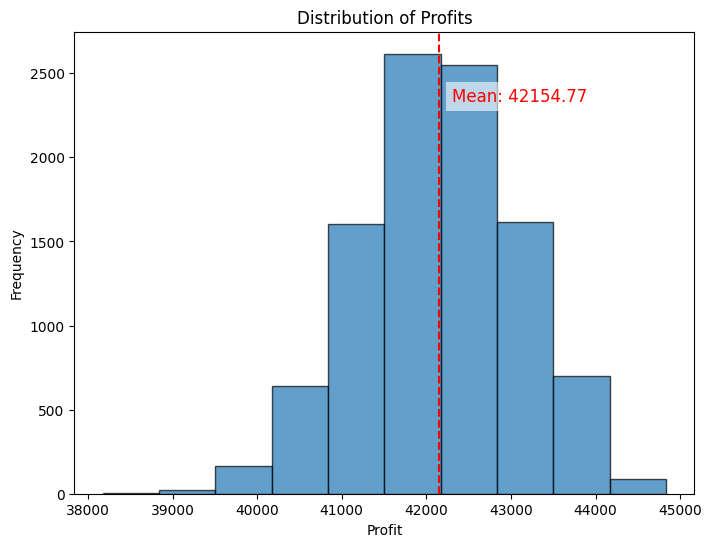

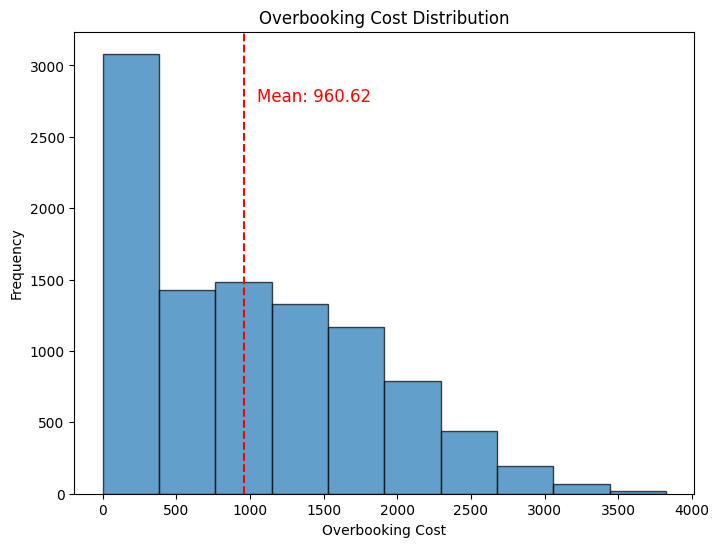

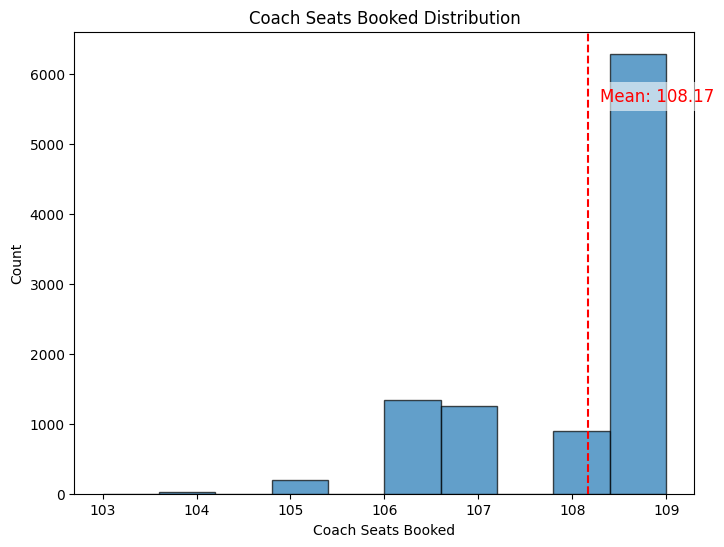

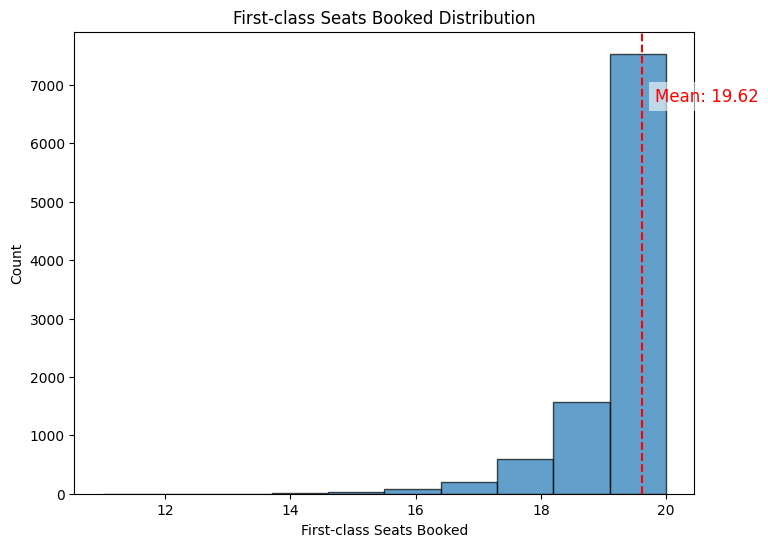

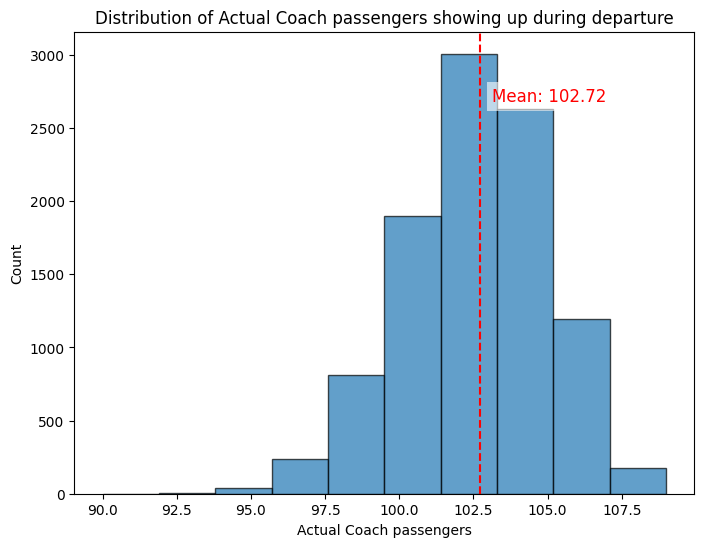

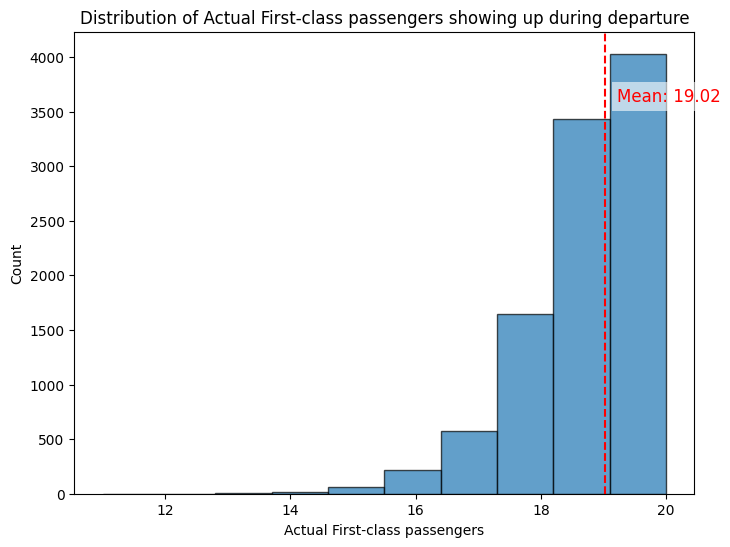

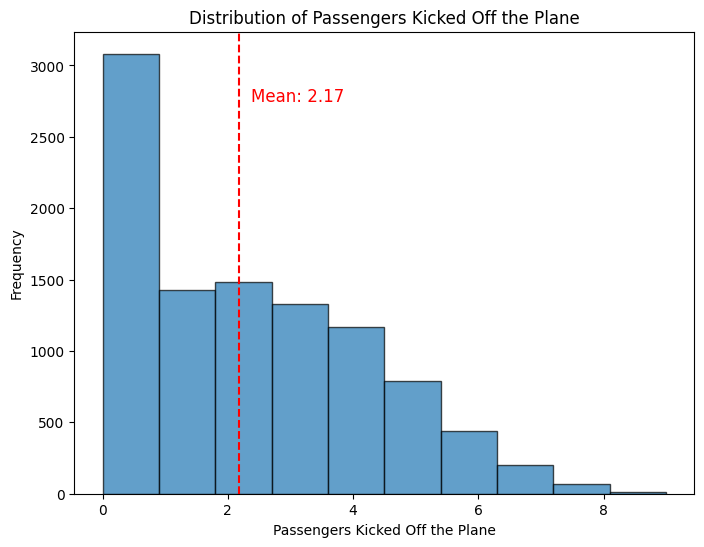

In [24]:
graph_generator(profits_list, cost_list, tc_list, tf_list, c_actual_list, tf_act_list, ctoout_count_list)

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3"> 
   
### **New Policy Simulation**

</font>
</div>

In [25]:
e=11
s_C_Values = np.arange(M_C + e + 1)  # All possible numbers of coach seats left, including extra seats.
s_C_N = len(s_C_Values)  # Count possible state values for coach seats.

V = np.zeros((s_C_N, s_F_N, tN))  # Initialize the value function matrix.
U = np.zeros((s_C_N, s_F_N, tN))  # Initialize the optimal choice variable matrix.

# Boundary/terminal condition: set values for the last day (when the flight takes off).
U[:, :, tN - 1] = 9  # Value 0 means no tickets for sale.

# Calculate the value matrix V based on the current state and number of coach and first-class seats available.
V = value_matrix_calc(V, s_C_N, s_F_N)

# Calculate the value matrix V and the optimal choice matrix U for pricing and profit calculation in mode 1.
V_2, U_2 = price_profit_calculator(V, U, s_C_N, s_F_N, mode=2)

In [26]:
nsim = 10000
profits_list_new = []
c_actual_list_new = []
tf_act_list_new = []
tc_list_new = []
tf_list_new = []
ctoout_count_list_new = []
cost_list_new = []
np.random.seed(10)
for sim in range(nsim):
    tc,tf,c_actual, tf_act,profit,ctoout_count,cost = simulator(U_2,9)
    profits_list_new.append(profit)
    tc_list_new.append(tc)
    tf_list_new.append(tf)
    c_actual_list_new.append(c_actual)
    tf_act_list_new.append(tf_act)
    ctoout_count_list_new.append(ctoout_count)
    cost_list_new.append(cost)

print('Average discounted profit when we decide to have 11 coach tickets to be overbooked with the new policy:',np.array(profits_list_new).mean())
print('Standard deviation of discounted profit when we decide to have 11 coach tickets to be overbooked with the new policy:',np.array(profits_list_new).std())

Average discounted profit when we decide to have 11 coach tickets to be overbooked with the new policy: 42006.37051998832
Standard deviation of discounted profit when we decide to have 11 coach tickets to be overbooked with the new policy: 836.4463148294413


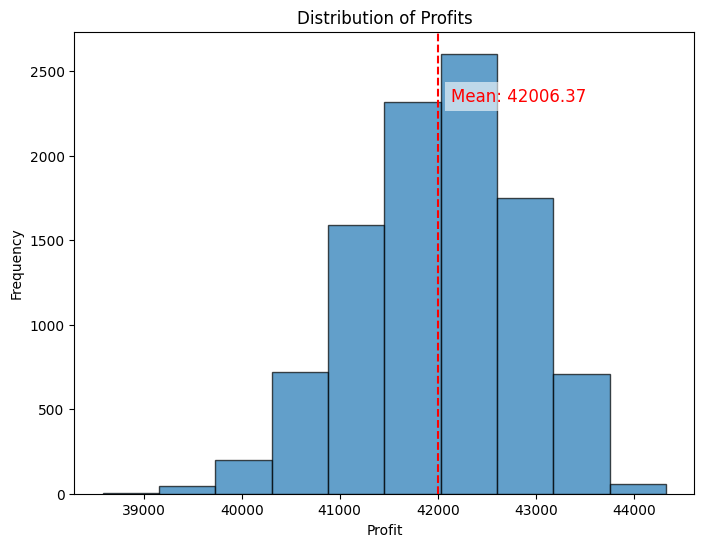

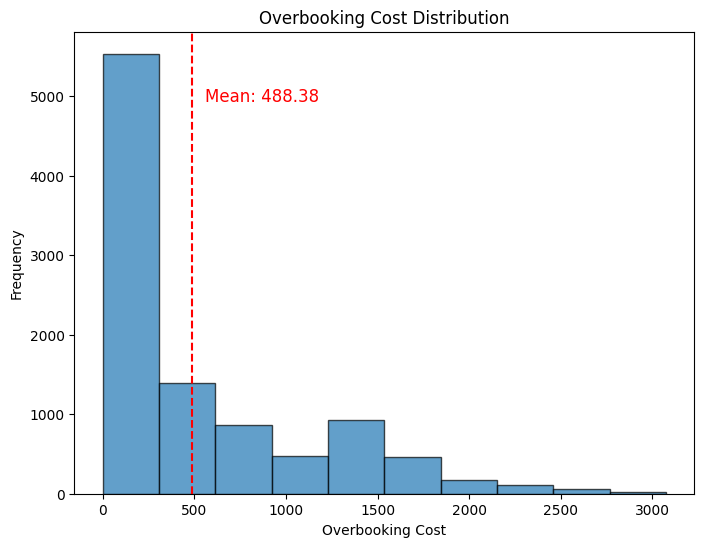

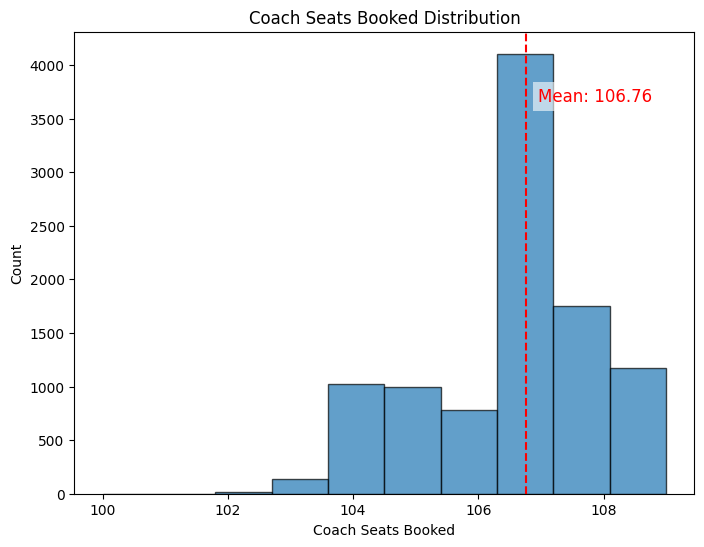

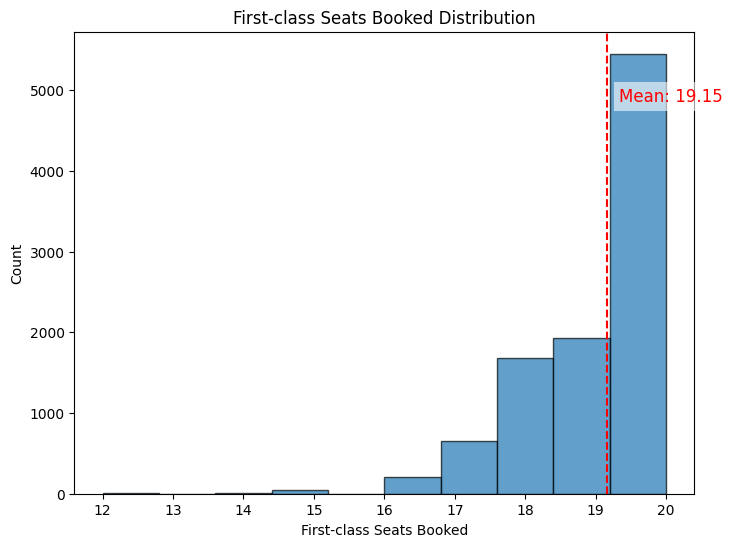

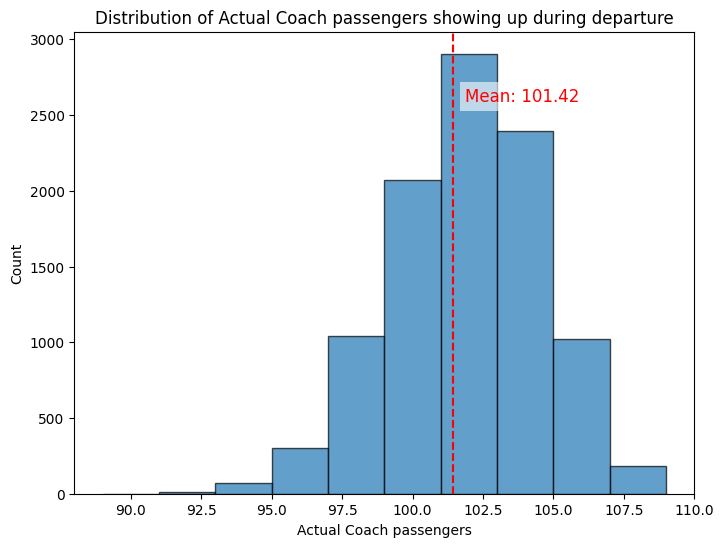

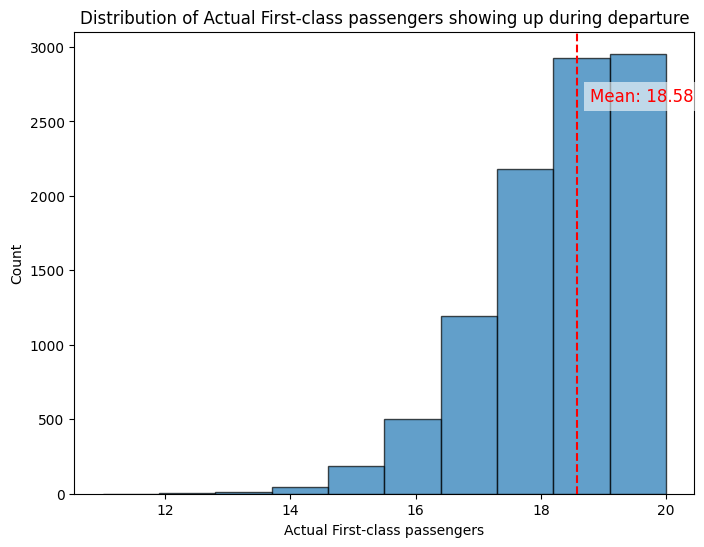

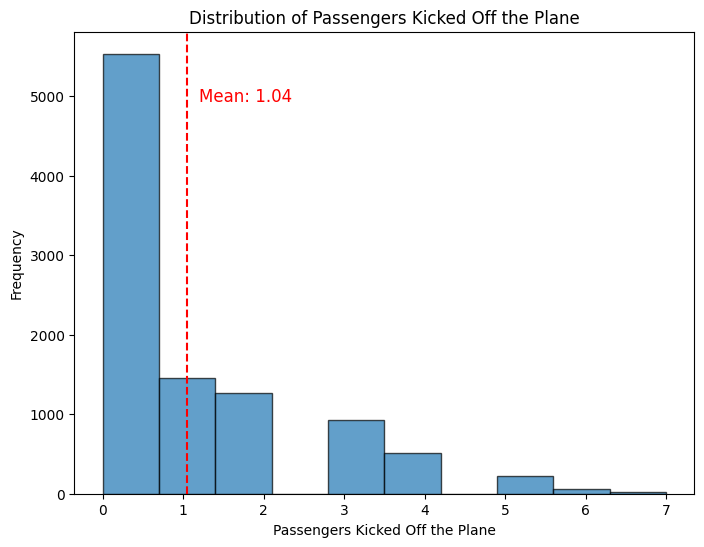

In [27]:
graph_generator(profits_list_new, cost_list_new, tc_list_new, tf_list_new, c_actual_list_new, tf_act_list_new, ctoout_count_list_new)

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3"> 
   
# **After running our simulation, the old policy looks better!**

</font>
</div>

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3"> 
   
# **Q 5**

Pretend you are an analyst in the sales department of a major airline. Your boss is interested in potentially overbooking flights. Your team has been asked to write a report about the effectiveness of overbooking. Write this project as if this is what you’re going to deliver to your boss. Your boss is pretty technical and understands optimization, so don’t be afraid to include quantitative material. Your boss is also busy, so be sure to include some visualizations to get the
important points across.
# 

Also, be sure to compare and contrast the two types of overbooking policies you examined here. For the purpose of your report, you can assume that your boss is interested in the probabilities listed with the project.

</font>
</div>

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3"> 
   
### Ans: Report Submitted

</font>
</div>

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3"> 
   
# **Thank You!**

</font>
</div>